# Unweighting events
$pp \rightarrow  4\ell + X$ events. 

 >__Created__: March 2020, Harrison B. Prosper, Tallahassee, USA<Br>
 >__Updated__: October 2022, HBP<br>
> **Updated**: Adapted for AEPSHEP 2024, Thailand
 > ATLAS Open Data

Prepare data for hzz4l notebooks.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline


# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

# set to False if you do not have a LaTex installation
mp.rc('text', usetex=True)

### Load weighted data

In [67]:
bkg = pd.read_csv('../datasets/atlas_opendata_4l_ggf.csv.gz')
bkg['target'] = -1

sig = pd.read_csv('../datasets/atlas_opendata_4l_vbf.csv.gz')
sig['target'] =  1

sig[:5]

,weight,mass4l,detajj,massjj,target
0,3.079892e-07,120.716200,0.072145,75.791751,1
1,8.116760e-07,118.369495,-1.000000,-1.000000,1
2,5.452208e-07,120.988837,0.111161,215.393826,1
3,4.036570e-07,124.299057,0.918324,32.148679,1
4,5.467027e-07,124.401753,3.442659,291.253348,1


### Apply filters

In [68]:
bkg = bkg[bkg.massjj >    0]
bkg = bkg[bkg.mass4l >= 100]
bkg = bkg[bkg.mass4l <= 135]

sig = sig[sig.massjj >    0]
sig = sig[sig.mass4l >= 100]
sig = sig[sig.mass4l <= 135]

bkg.weight.sum(), len(bkg), sig.weight.sum(), len(sig)

(0.2225924314999958, 41503, 0.026004976382686697, 62931)

### Compute effective counts

In [69]:
def effective_count(df):
    w = df.weight
    w1sum = w.sum()
    w2sum = (w**2).sum()
    count = int(w1sum**2 / w2sum)
    return count

In [70]:
bkgeff = effective_count(bkg)
sigeff = effective_count(sig)
fb = bkgeff/len(bkg)
fs = sigeff/len(sig)
fb, fs

(0.8596487000939691, 0.8579396481861086)

### Split data before unweighting
Since we are using a bootstrap method to unweight events, duplicate events can occur. Therefore, it is important to split the weighted events first before their unweighting so that the training, validation, and test sets are strictly disjoint.

In [71]:
def split_data(df):
    N = len(df)
    ntrain = int(0.80 * N)
    nvalid = int(0.10 * N)
    ntest  = N - ntrain - nvalid
    print(ntrain, nvalid, ntest)
    
    train  = df[:ntrain].reset_index()
    valid  = df[ntrain:ntrain+nvalid].reset_index()
    test   = df[ntrain+nvalid:].reset_index()

    return train, valid, test

In [72]:
sig_train, sig_valid, sig_test = split_data(sig)
bkg_train, bkg_valid, bkg_test = split_data(bkg)

50344 6293 6294
33202 4150 4151


In [73]:
sig_train[:5]

,index,weight,mass4l,detajj,massjj,target
0,0,3.079892e-07,120.716200,0.072145,75.791751,1
1,2,5.452208e-07,120.988837,0.111161,215.393826,1
2,3,4.036570e-07,124.299057,0.918324,32.148679,1
3,4,5.467027e-07,124.401753,3.442659,291.253348,1
4,5,1.143371e-09,119.462192,3.396478,290.039498,1


In [74]:
bkg_train[:5]

,index,weight,mass4l,detajj,massjj,target
0,0,0.000004,123.582292,0.284106,61.398222,-1
1,1,0.000008,124.873343,1.337551,103.772326,-1
2,4,0.000004,124.017472,0.999458,94.890323,-1
3,5,0.000007,123.023175,3.219344,281.517988,-1
4,6,0.000006,123.183463,0.762342,45.144049,-1


### Simple routine to plot distributions of variables

In [75]:
def plot_var(d, name, dw=None, xbins=50):
    
    # get lower and upper x-limits of histogram
    x    = d[name]
    xmin = x.min()
    xmean= x.mean()
    xstd = x.std()
    xmax = xmean + 3.5 * xstd
    
    # set size of figure
    fig = plt.figure(figsize=(5, 4)) 
    ax  = fig.add_subplot(1, 1, 1)
        
    ax.set_xlabel(name, fontsize=14)
    ax.set_xlim(xmin, xmax)
    ax.hist(x, 
            bins=xbins,
            density=True,
            color='steelblue', 
            histtype='stepfilled',
            alpha=0.4,
            range=(xmin, xmax), 
            label='unweighted')
    try:
        ax.hist(dw[name], 
                weights=dw.weight,
                bins=xbins,
                density=True,
                color='red',
                linewidth=2,
                histtype='step',
                range=(xmin, xmax), 
                label='weighted')
        ax.legend()
    except:
        pass
        
    fig.tight_layout()
    plt.show()

Plot weight distribution of background

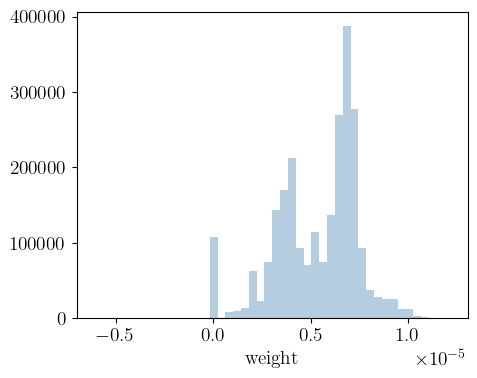

In [76]:
plot_var(bkg_test, 'weight')

### A slightly modified binary search

In [77]:
#------------------------------------------------------------------------------
# File: unweight.py
# Description: Create unweighted events from weighted ones.
# Created: 19-Dec-2005 Harrison B. Prosper
#----------------------------------------------------------------
# Binary search - Slightly modified version of 
# Prof. Jessen Havill's program (Denison University)
#----------------------------------------------------------------
def binsearch(L, item):
    first = 0
    last = len(L) - 1   

    found = False
    while (first <= last) and not found:
        mid = int((first + last) / 2)
        if item <= L[mid]: 
            last = mid       
        elif item > L[mid]:
            first = mid + 1
            
        if first >= last:
            mid = first
            found = True

        if found: return mid
    return -1

### Unweight events

__Method__:

The basic idea is to select events with a probability proportional to the event weight.
  1. Compute cumulative distribution of event weights (*cdf*)
  1. Compute sum of weights *cdfmax*
  1. Compute effective count: $N = \mathbb{E}^2(w) / \mathbb{E}(w^2)$
  1. Sample $w \sim \textrm{uniform}(0, cdfmax)$
  1. Use a binary search to find in which event $k$ $w$ lies and add the event number to the set of selected events.
  1. Repeat 4 and 5 $N$ times.

In [78]:
def unweight_events(data):
    
    # compute cumulative distribution
    wt  = data.weight.to_numpy()
    cdf = np.cumsum(wt)
    cdfmax = cdf[-1]
    
    # compute effective sample count
    w1 = wt.sum()
    w2 =(wt**2).sum()
    N  = int(w1**2 / w2)
    
    # sample with replacement to unweight events
    select = []
    for i in range(N):
        w = rnd.uniform(0, cdfmax)
        k = binsearch(cdf, w)
        if k < 0:
            raise ValueError('k is negative => failed binsearch!')
        
        select.append(k)
        
    print('Effective sample size: %10d' % N)
    
    # return selected events
    D = data.iloc[select].sample(frac=1).reset_index()
    D = D.drop(['weight', 'level_0', 'index'], axis=1)
    return D

Unweight Higgs events

In [79]:
sig_train_u = unweight_events(sig_train)
sig_valid_u = unweight_events(sig_valid)
sig_test_u  = unweight_events(sig_test)

Effective sample size:      43192
Effective sample size:       5395
Effective sample size:       5404


Unweight background events

In [80]:
bkg_train_u = unweight_events(bkg_train)
bkg_valid_u = unweight_events(bkg_valid)
bkg_test_u  = unweight_events(bkg_test)

Effective sample size:      28560
Effective sample size:       3557
Effective sample size:       3560


In [81]:
bkg_test_u[:5]

,mass4l,detajj,massjj,target
0,125.197810,1.984506,91.458166,-1
1,124.897897,1.973783,85.440388,-1
2,125.071274,3.446349,169.422859,-1
3,123.251477,2.703899,133.837052,-1
4,123.500626,1.499506,78.232923,-1


### Check that unweighting was successful

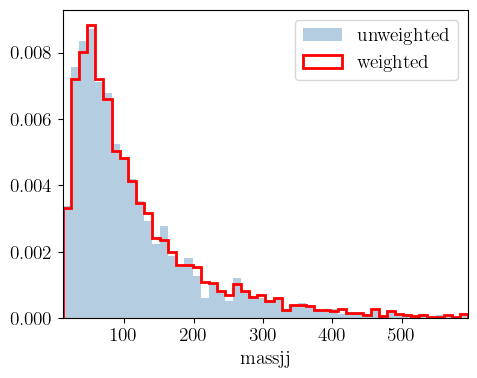

In [84]:
WHICH= 'bkg'   # sig or bkg
TYPE = 'test'  # train, valid, or test

df   = eval('%s_%s'   % (WHICH, TYPE))
df_u = eval('%s_%s_u' % (WHICH, TYPE))

plot_var(df_u, 'massjj', df)

### Save unweighted events to csv file

In [86]:
def to_csv(sig, bkg, filename, N=-1):
    if N > 0:
        N = min(len(sig), len(bkg), N)
        sig = sig[:N]
        bkg = bkg[:N]

    # concatenate signal and background events
    df = pd.concat([sig, bkg])
    
    # and shuffle rows in dataframe
    df = df.sample(frac=1)

    df.to_csv(filename, index=False)
    print('saved %d rows' % len(df))
    
    return df

In [88]:
# last argument is the number of events / signal or background
# so that we create balanced data sets
df = to_csv(sig_train_u, bkg_train_u, '../datasets/atlas_opendata_4l_train.csv.gz', 25000)
df = to_csv(sig_valid_u, bkg_valid_u, '../datasets/atlas_opendata_4l_valid.csv.gz',  2500)
df = to_csv(sig_test_u,  bkg_test_u,  '../datasets/atlas_opendata_4l_test.csv.gz',   2500)
df[:10]

saved 50000 rows
saved 5000 rows
saved 5000 rows


,mass4l,detajj,massjj,target
1721,121.788477,4.155531,814.198138,1
2305,125.814360,3.432720,293.062246,1
603,119.421988,3.176038,187.240780,-1
1922,119.961254,0.304112,42.068307,-1
270,119.280590,4.329558,890.590023,1
1050,119.712648,0.434336,147.711852,-1
194,127.064029,2.069314,236.763752,-1
2336,125.126476,3.926730,753.524053,1
1175,124.910131,1.827156,202.609735,-1
418,108.283104,2.044817,105.590852,-1


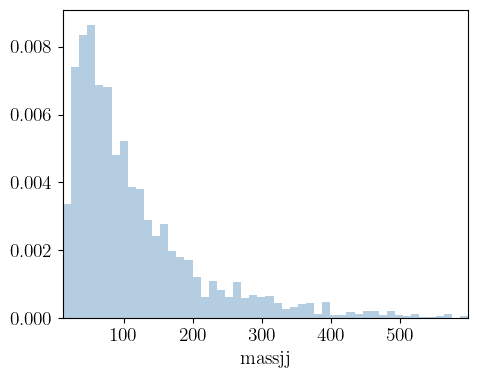

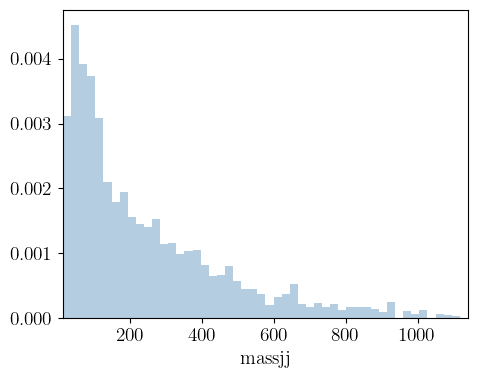

In [91]:
select = df.target<0.5
plot_var(df[select], 'massjj', df[select])

select = df.target>0.5
plot_var(df[select], 'massjj', df[select])